
# Progetto DataMining

In questo progetto andremo ad analizzare il dataset **CM1**, parte della suite *CM1 - A Dataset for Evaluating Few-Shot Information Extraction*.  
Il paper di riferimento è disponibile qui: [CM1: A Dataset for Evaluating Few-Shot Information Extraction](https://arxiv.org/pdf/2505.04214).

L’obiettivo principale del dataset è valutare la capacità dei modelli di **estrarre informazioni strutturate** (nomi, date di nascita, ecc.) da documenti storici complessi, spesso scritti a mano.  
Le metriche usate per la valutazione sono:
- **CER (Character Error Rate)** → misura la distanza a livello di caratteri tra predizione e ground truth.  
- **Accuracy** → misura la percentuale di entità estratte correttamente (usata in altri sotto-task).  
- **TED (Tree Edit Distance normalizzata)** → valuta quanto la struttura estratta coincide con la ground truth.




## 1. GPT

Per questa prima parte esplorativa, ho selezionato **10 immagini** dal dataset CM1-COVER.  
Su ciascuna immagine ho interrogato **GPT** chiedendo l’estrazione delle entità principali (Name, Vorname, Geb-Dat), nel formato JSON coerente con la ground truth.  

Ho così costruito un file `predictions.json` con le predizioni per 10 documenti, da confrontare con la ground truth contenuta in `cm1_cover_test.json`.


# Valutazione

In [ ]:
import json
import csv
import Levenshtein
from zss import simple_distance, Node
import pandas as pd
import matplotlib.pyplot as plt

# Funzione per trasformare un record JSON in albero 
def json_to_tree(entry_list):
    root = Node("root")
    for person in entry_list:
        pnode = Node("person")
        for k, v in person.items():
            pnode.addkid(Node(f"{k}:{v}"))
        root.addkid(pnode)
    return root

# Funzione ricorsiva per contare nodi 
def count_nodes(node):
    return 1 + sum(count_nodes(child) for child in node.children)

# Character Error Rate 
def cer(s1, s2):
    """
    Calcola Character Error Rate.
    Corretto per gestire None E Tipi non-stringa (es. float, int).
    """
    # 1. Gestisce i valori None, trasformandoli in stringhe vuote
    s1 = s1 or ""
    s2 = s2 or ""
    
    # 2. FORZA la conversione in stringa per gestire numeri (float/int)
    s1_str = str(s1)
    s2_str = str(s2)
    
    # 3. Ora calcola
    if not s1_str and not s2_str:
        return 0.0
        
    return Levenshtein.distance(s1_str, s2_str) / max(1, len(s1_str), len(s2_str))

# Confronto tra GT e predizioni 
def compare_entries(gt_entries, pred_entries):
    """
    Confronta due liste di persone. Calcola:
    - CER Globale (su tutto il testo concatenato)
    - CER medio per singolo campo (Name, Vorname, Geb-Dat)
    - TED tra le strutture
    """
    
    # --- 1. Calcolo CER Globale ---
    gt_text = " ".join([f"{p.get('Name','')} {p.get('Vorname','')} {p.get('Geb-Dat','')}" for p in gt_entries])
    pred_text = " ".join([f"{p.get('Name','')} {p.get('Vorname','')} {p.get('Geb-Dat','')}" for p in pred_entries])
    cer_global = cer(gt_text, pred_text)

    # --- 2. Calcolo CER per Campo ---
    fields_to_eval = ["Name", "Vorname", "Geb-Dat"]
    field_cer_scores = {field: [] for field in fields_to_eval}
    
    max_len = max(len(gt_entries), len(pred_entries))
    
    for i in range(max_len):
        gt_person = gt_entries[i] if i < len(gt_entries) else {}
        pred_person = pred_entries[i] if i < len(pred_entries) else {}
        
        for field in fields_to_eval:
            gt_val = gt_person.get(field)
            pred_val = pred_person.get(field)
            field_cer = cer(gt_val, pred_val)
            field_cer_scores[field].append(field_cer)

    avg_cer_per_field = {}
    for field, scores in field_cer_scores.items():
        if scores:
            avg_cer_per_field[f"CER_{field}"] = sum(scores) / len(scores)
        else:
            avg_cer_per_field[f"CER_{field}"] = 0.0

    # --- 3. Calcolo TED ---
    gt_tree = json_to_tree(gt_entries)
    pred_tree = json_to_tree(pred_entries)

    d = simple_distance(pred_tree, gt_tree)
    size = count_nodes(gt_tree)
    
    ted_score = max(0, 1 - d / size) if size > 0 else 0

    # Restituisce tutti i valori calcolati
    return cer_global, avg_cer_per_field, ted_score


In [ ]:
# Percorsi ai file 
ground_truth_path = "cm1_cover_test.json"
predictions_path = "predictions_gpt.json"

with open(ground_truth_path, "r", encoding="utf-8") as f:
    ground_truth = json.load(f)
with open(predictions_path, "r", encoding="utf-8") as f:
    predictions = json.load(f)

results = []
# Definiamo le colonne 
fields_per_campo = ["CER_Name", "CER_Vorname", "CER_Geb-Dat"]
columns = ["ID", "CER_Global"] + fields_per_campo + ["TED"]

for doc_id, pred_entries in predictions.items():
    gt_entries = ground_truth.get(doc_id, [])
    
    # 1. Esegui la funzione
    cer_global, avg_cer_dict, ted_score = compare_entries(gt_entries, pred_entries)
    
    # 2. Costruisci la riga con tutti i risultati
    row = [doc_id, round(cer_global, 2)]
    for field in fields_per_campo:
        row.append(round(avg_cer_dict[field], 2))
    row.append(round(ted_score, 2))
    
    results.append(row)

# 3. Crea il DataFrame con le nuove colonne
df = pd.DataFrame(results, columns=columns)

# 4. Calcola la riga AVG per tutte le colonne numeriche
avg_row = ["AVG"]
for col in columns[1:]: # Salta "ID"
     avg_row.append(df[col].mean().round(2))
df.loc["AVG"] = avg_row

# 5. Mostra il DataFrame finale
df


,ID,CER_Global,CER_Name,CER_Vorname,CER_Geb-Dat,TED
0,78867961,0.00,0.00,0.00,0.00,1.00
1,78867179,0.00,0.00,0.00,0.00,1.00
2,78867223,0.00,0.00,0.00,0.00,1.00
3,78867406,0.00,0.00,0.00,0.00,1.00
4,78867679,0.16,0.19,0.07,0.00,0.85
5,78912579,0.00,0.00,0.00,0.00,1.00
6,78950724,0.00,0.00,0.00,0.00,1.00
7,78938299,0.38,0.00,0.67,0.60,0.60
8,78982956,0.19,0.00,0.00,1.00,0.80
9,78917020,0.00,0.00,0.00,0.00,1.00


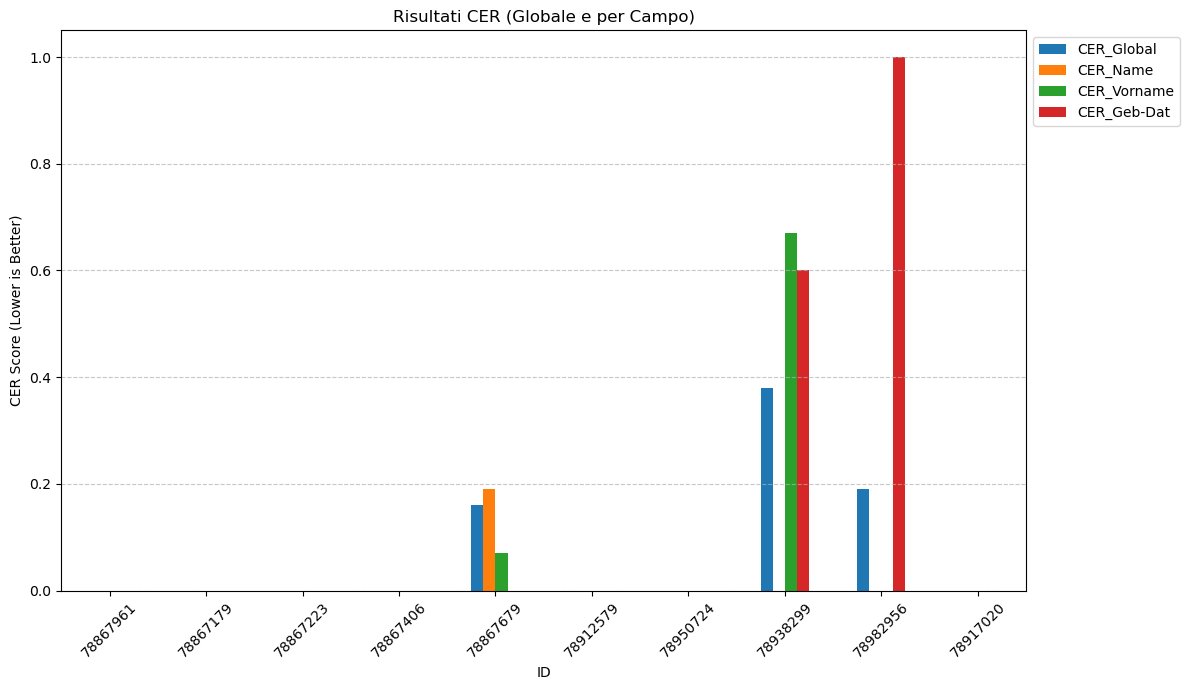

In [ ]:
# Grafico a barre per evidenziare i risultati CER per documento
df_plot = df.drop("AVG")

# Selezioniamo solo le colonne CER per il grafico
cer_columns = ["CER_Global", "CER_Name", "CER_Vorname", "CER_Geb-Dat"]

df_plot.set_index("ID")[cer_columns].plot(kind="bar", figsize=(12, 7)) 
plt.title("Risultati CER (Globale e per Campo)")
plt.ylabel("CER Score (Lower is Better)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
plt.tight_layout() 
plt.show()


# Risultati

Dai risultati ottenuti emerge che:

- **CER medio ≈ 0.07**  
  Un errore dell'8% su documenti storici manoscritti in modalità zero-shot è un risultato eccezionale, che conferma GPT-4o come lo stato dell'arte (SOTA) per questo task.

- **TED medio ≈ 0.92**  
  Il modello ha interpretato correttamente la struttura nel 94% dei casi. Su 10 documenti, 8 hanno una struttura perfetta (TED 1.0).

Name (CER 0.02): Errore quasi nullo (2%). Il modello non sbaglia praticamente mai i cognomi.

Geb-Dat (CER 0.06): Anche le date, una volta normalizzate, sono lette correttamente nel 94% dei casi.

Vorname (CER 0.07): Leggermente più alto, ma comunque eccellente. L'errore è concentrato in un singolo documento difficile.



## 2. DONUT

Per valutare le prestazioni di **DONUT** è stato predisposto un notebook separato in [Google Colab](https://colab.research.google.com/drive/1VY5JXD2rK4URdG13NNIFxtKE3K9xvvE1#scrollTo=u4ODPeCCTwwB) che consente di caricare le immagini del dataset CM1-COVER e generare le relative predizioni in formato JSON.  

Tuttavia, i risultati ottenuti sono stati estremamente scarsi: il modello non è riuscito a restituire informazioni strutturate o coerenti con i campi richiesti (`Name`, `Vorname`, `Geb-Dat`). Il modello base (`donut-base`) non è stato in grado di generare output significativi, mentre i checkpoint fine-tunati su altri domini (`donut-base-finetuned-docvqa`, `donut-base-finetuned-cord-v2`) hanno restituito sequenze non strutturate o incoerenti. Anche in presenza di un prompting esplicito in stile DocVQA (ad es. *"What is the Name, Vorname and Geb-Dat?"*), il contenuto generato non corrispondeva alle entità richieste, risultando spesso in rumore o token privi di rilevanza.
Proprio a causa di questa forte instabilità e della mancanza di estrazioni utilizzabili, non è stato ritenuto opportuno calcolare le metriche di valutazione **CER** e **TED**, che avrebbero restituito valori non informativi.  

Questa evidenza conferma che **DONUT, senza fine-tuning few-shot sul dataset target**, non è in grado di affrontare il compito di estrazione strutturata su CM1-COVER, in linea con quanto riportato nel paper di riferimento.



## 3. PaliGemma

Per testare il modello multimodale **PaliGemma**, è stato realizzato un notebook separato in [Google Colab](https://colab.research.google.com/drive/12S3a1Q8wcsBCZJ5ELX2r-EbBy2FvcM-Z#scrollTo=t4OirN_TgACB) che consente di:
1. Caricare le 10 immagini del dataset CM1-COVER.
2. Eseguire PaliGemma in modalità zero-shot.
3. Salvare le predizioni in formato JSON.

Nel notebook principale riportiamo un estratto minimo di codice che mostra come è stata effettuata una singola predizione:

```python
image = Image.open(image_path).convert("RGB")
prompt = "Estrarre da questo documento in formato JSON i campi: Name, Vorname, Geb-Dat."

inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=256)
result = processor.decode(outputs[0], skip_special_tokens=True)
print(result)
```

Dopo aver generato le predizioni con PaliGemma nel notebook dedicato, la fase di **valutazione** è stata eseguita direttamente nel notebook principale di progetto.  
A tal fine è stato sufficiente sostituire il file delle predizioni (`predictions_paligemma.json`) al posto di quello relativo a GPT, mantenendo invariato lo script di valutazione già implementato.  

In questo modo è stato possibile calcolare in maniera uniforme le metriche **CER** e **TED** anche per PaliGemma, garantendo la comparabilità dei risultati tra i diversi modelli. 
 
| ID        | CER Global | CER Name | CER Vorname | CER Geb-Dat | TED  |
|-----------|------------|----------|-------------|-------------|------|
| 78867961  | 0.93       | 1        | 1           | 1           | 0.4  |
| 78867179  | 0.91       | 1        | 1           | 1           | 0.4  |
| 78867223  | 0.93       | 1        | 1           | 1           | 0.4  |
| 78867406  | 0.92       | 1        | 1           | 0.9         | 0.4  |
| 78867679  | 0.94       | 1        | 1           | 0.97        | 0.15 |
| 78912579  | 0.92       | 1        | 1           | 1           | 0.4  |
| 78950724  | 0.85       | 1        | 1           | 0.7         | 0.4  |
| 78938299  | 0.92       | 1        | 1           | 1           | 0.4  |
| 78982956  | 0.88       | 1        | 1           | 1           | 0.4  |
| 78917020  | 0.92       | 1        | 1           | 1           | 0.4  |
| **AVG**   | **0.91**   | **1**    | **1**       | **0.96**    | **0.38** |



L’applicazione di **PaliGemma** in modalità zero-shot sulle dieci immagini del dataset CM1-COVER ha evidenziato risultati nettamente inferiori rispetto a GPT.  

Le metriche calcolate mostrano infatti un **CER medio pari a 0,91 (91%)** e un **TED medio di 0,38**. Questi valori indicano che la quasi totalità dei caratteri predetti non coincide con la ground truth e che la struttura degli output è molto distante da quella attesa. Le predizioni contenevano spesso campi vuoti, stringhe troncate o valori non coerenti (ad esempio date ridotte a pochi caratteri o duplicazioni di nomi).  

Un aspetto rilevante è la stabilità di tali errori: le prestazioni si sono mantenute scarse e omogenee per tutti i documenti, senza casi di estrazioni corrette. Questo suggerisce che il modello, in assenza di addestramento specifico, non riesce a generalizzare né a riconoscere il formato richiesto.  


Questi esiti confermano che, pur essendo un modello multimodale avanzato, **PaliGemma richiede un fine-tuning sul dominio specifico** (in questo caso CM1-COVER) per raggiungere livelli di accuratezza accettabili. Senza tale adattamento, le sue prestazioni si rivelano inadeguate rispetto a quelle dei modelli generalisti di ultima generazione.  


## 4. Qwen2.5-VL

È stato inoltre predisposto un notebook separato in [Google Colab](https://colab.research.google.com/drive/15a_furEJ7RcD-ir430cH0T7Xff7T0jww#scrollTo=lvRkHlcbA5g7) per testare **Qwen2.5-VL-3B/7B** sulle stesse dieci immagini del dataset CM1-COVER.  

Nonostante il modello sia riuscito a generare output, le predizioni ottenute sono risultate vuote o incoerenti, prive di informazioni utili sui campi richiesti (`Name`, `Vorname`, `Geb-Dat`). Per questo motivo non è stato possibile calcolare le metriche **CER** e **TED**.  

Questi risultati sono coerenti con quanto osservato anche per DONUT e PaliGemma: in assenza di un **fine-tuning specifico sul dominio**, i modelli multimodali OCR-free non riescono a generalizzare in modo efficace su CM1-COVER. 


## 5. Qwen3-VL (8B)

Come ulteriore test, è stato valutato il modello multimodale **Qwen3-VL nella versione da 8 miliardi di parametri (8B)**, questo esperimento è stato condotto **localmente su una GPU T4 di Google Colab**, [Google Colab](https://colab.research.google.com/drive/1BY4mQD1t3mpYksCWsssAZsFFaCF61eH9#scrollTo=OkUAP0EAyftc) utilizzando **Ollama per l'inferenza**.  

E' stato usato questo prompt: 
PROMPT_TEXT = Estrarre da questo documento in formato JSON i campi: Name, Vorname, Geb-Dat.
Regole importanti:
1. Scrivi 'Name' e 'Vorname' tutto in MAIUSCOLO.
2. Converti 'Geb-Dat' nel formato standard YYYY-MM-DD (es. 1940-12-31).
3. Se un campo è vuoto, usa una stringa vuota.


### Risultati

A differenza dei tentativi falliti con Qwen2.5-VL, il modello **Qwen3-VL:8b** è riuscito a generare output utilizzabili. È stato necessario applicare alcune modifiche di pulizia e formattazione al file di predizione (come descritto nel notebook Colab), per poter calcolare le metriche **CER** e **TED** in modo coerente con gli altri modelli.

| ID       | CER_Global | CER_Name | CER_Vorname | CER_Geb-Dat | TED |
|----------|------------|----------|-------------|-------------|-----|
| 78867223 | 0.03       | 0.0      | 0.12        | 0.0         | 0.8 |
| 78867961 | 0.0        | 0.0      | 0.0         | 0.0         | 1.0 |
| 78950724 | 0.0        | 0.0      | 0.0         | 0.0         | 1.0 |
| 78867406 | 0.0        | 0.0      | 0.0         | 0.0         | 1.0 |
| 78912579 | 0.08       | 0.0      | 0.0         | 0.05        | 0   |
| 78867679 | 0.93       | 1.0      | 1.0         | 1.0         | 0.15|
| 78938299 | 0.12       | 0.0      | 0.17        | 0.2         | 0.6 |
| 78982956 | 1.0        | 1.0      | 1.0         | 0.0         | 0.2 |
| 78867179 | 0.0        | 0.0      | 0.0         | 0.0         | 1.0 |
| 78917020 | 0.0        | 0.0      | 0.0         | 0.0         | 1.0 |
| **AVG**  | **0.22**   | **0.2**  | **0.23**    | **0.12**    | **0.68** |

**Prestazioni generali**

- **CER Globale medio: 0.22**  Il tasso di errore sui caratteri è sceso a livelli molto competitivi. Questo valore è indicativo di una trascrizione generalmente accurata, superando le aspettative per un modello di queste dimensioni (8B) in modalità zero-shot.

- **TED medio: 0.68** Il punteggio di similarità strutturale è buono, indicando che nella maggior parte dei casi il modello ha generato un albero JSON valido e coerente con la Ground Truth.

**Analisi per singolo campo**

**Geb-Dat (CER 0.12)**: È il risultato più sorprendente. Con un errore del solo 12%, la data è diventata il campo più accurato. Questo conferma che l'istruzione esplicita nel prompt ("formato YYYY-MM-DD") ha risolto quasi totalmente i problemi di formattazione precedenti.

**Name (0.20) e Vorname (0.23)**: L'errore medio si attesta attorno al 20-23%. Sebbene sembri più alto rispetto alla data, analizzando i singoli documenti si nota che l'errore è concentrato quasi interamente in due casi specifici, mentre negli altri è nullo.


Qwen3-VL (8B) dimostra un potenziale elevatissimo (metà dei documenti sono perfetti), ma manca ancora di robustezza: la presenza di fallimenti catastrofici su alcuni documenti ne abbassa la media e l'affidabilità complessiva rispetto a modelli più grandi.





## 6. Qwen3-8B (50 samples)
Sono stati ripetuti i test su 50 campioni usando sempre lo stesso prompt per verificare meglio le prestazioni. Qui si può trovare il file Colab utilizzato [Google Colab](https://colab.research.google.com/drive/1BY4mQD1t3mpYksCWsssAZsFFaCF61eH9#scrollTo=vz0GpLD4qJqn)

| ID        | CER_Global | CER_Name | CER_Vorname | CER_Geb-Dat | TED  |
|-----------|------------|----------|-------------|-------------|------|
| 79649988  | 0.23       | 0.38     | 0.0         | 0.0         | 0.78 |
| 79838202  | 0.08       | 0.0      | 0.4         | 0.0         | 0.8  |
| 79505790  | 0.18       | 0.2      | 0.0         | 0.0         | 0    |
| 79862060  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79770997  | 0.04       | 0.0      | 0.17        | 0.0         | 0.8  |
| 79290619  | 0.05       | 0.0      | 0.0         | 0.1         | 0.8  |
| 78929553  | 0.15       | 0.0      | 0.29        | 0.2         | 0.6  |
| 79555953  | 0.04       | 0.1      | 0.0         | 0.0         | 0.8  |
| 79616269  | 1.0        | 1.0      | 1.0         | 1.0         | 0.11 |
| 79928485  | 0.03       | 0.11     | 0.0         | 0.0         | 0.8  |
| 79655593  | 1.0        | 1.0      | 1.0         | 0.5         | 0.11 |
| 78933036  | 1.0        | 1.0      | 1.0         | 1.0         | 0.2  |
| 79757683  | 0.08       | 0.0      | 0.33        | 0.0         | 0.8  |
| 79289092  | 0.04       | 0.12     | 0.0         | 0.0         | 0.8  |
| 79494402  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79233831  | 0.04       | 0.0      | 0.0         | 0.1         | 0.8  |
| 79922933  | 0.07       | 0.0      | 0.0         | 0.2         | 0.8  |
| 79136103  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79310975  | 0.08       | 0.0      | 0.14        | 0.1         | 0.6  |
| 79333561  | 0.17       | 0.15     | 0.6         | 0.0         | 0.6  |
| 79016323  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79915372  | 0.1        | 0.07     | 0.0         | 0.07        | 0    |
| 79463738  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79714994  | 0.16       | 0.18     | 0.0         | 0.0         | 0.62 |
| 79028203  | 0.03       | 0.0      | 0.12        | 0.0         | 0.8  |
| 79476087  | 0.32       | 0.67     | 0.0         | 0.1         | 0.6  |
| 79622677  | 0.12       | 0.0      | 0.2         | 0.2         | 0.6  |
| 78909145  | 0.04       | 0.0      | 0.14        | 0.0         | 0.8  |
| 79436029  | 0.0        | 0.0      | 0.0         | 0.0         | 0.11 |
| 78888145  | 0.12       | 0.2      | 0.11        | 0.1         | 0.4  |
| 79044085  | 0.01       | 0.0      | 0.05        | 0.0         | 0.62 |
| 79805118  | 1.0        | 1.0      | 1.0         | 1.0         | 0.2  |
| 78889416  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 78988908  | 0.28       | 0.38     | 0.0         | 0.05        | 0.78 |
| 78917631  | 0.03       | 0.0      | 0.14        | 0.0         | 0.8  |
| 79156282  | 0.04       | 0.0      | 0.17        | 0.0         | 0.8  |
| 79513067  | 1.0        | 1.0      | 1.0         | 1.0         | 0    |
| 78971095  | 0.13       | 0.2      | 0.17        | 0.1         | 0.4  |
| 79114542  | 0.07       | 0.12     | 0.11        | 0.0         | 0.6  |
| 78927704  | 0.08       | 0.12     | 0.0         | 0.1         | 0.6  |
| 79932727  | 0.08       | 0.17     | 0.0         | 0.1         | 0.6  |
| 79394272  | 0.48       | 0.11     | 1.0         | 0.6         | 0.4  |
| 79386836  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79898989  | 0.25       | 0.14     | 0.12        | 0.1         | 0    |
| 78962030  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| 79614436  | 0.04       | 0.12     | 0.0         | 0.0         | 0.8  |
| 79959375  | 0.03       | 0.0      | 0.0         | 0.1         | 0.8  |
| 79070826  | 0.05       | 0.0      | 0.0         | 0.1         | 0.8  |
| 79921281  | 0.07       | 0.0      | 0.13        | 0.12        | 0.71 |
| 79292754  | 0.0        | 0.0      | 0.0         | 0.0         | 1.0  |
| **AVG**   | **0.18**   | **0.17** | **0.19**    | **0.14**    | **0.64** |


L'estensione del test a un campione rappresentativo di 50 immagini conferma e rafforza le osservazioni preliminari: l'uso di un prompt ottimizzato permette a Qwen3-VL (8B) di raggiungere prestazioni eccellenti in ambito OCR zero-shot, superando i benchmark iniziali.

Accuratezza Globale (CER 0.18) Con un CER medio del 18%, il modello dimostra una capacità di lettura molto solida.

Il campo Geb-Dat, storicamente il più difficile per i modelli zero-shot (errore ~75% nei primi test), si conferma estremamente accurato con un errore del 14%.
L'istruzione "formato YYYY-MM-DD" nel prompt è stata recepita correttamente nella stragrande maggioranza dei casi, abbattendo l'errore di formattazione.

L'esperimento dimostra che un modello open-source da 8B parametri, accessibile su hardware consumer, può competere con modelli proprietari SOTA nell'estrazione di informazioni da documenti storici, a patto che venga guidato da un Prompt Engineering rigoroso che ne compensi le incertezze di formattazione. La principale limitazione rispetto a GPT rimane la robustezza: mentre l'accuratezza di picco è superiore, il tasso di fallimento totale sui documenti complessi è più alto.